### Podstawy analizy kształtu

Przekształcenie obrazu do uproszczonej postaci wektorowej pozwala na analizę kształtu poszczególnych obiektów.
OpenCV oferuje kilka gotowych narzędzi, z których tutaj skupimy się głównie na _momentach_.
Pozostałe z nich pozostawie się do samodzielnego rozpoznania w miarę potrzeb - szczególnie polecam [ten przewodnik](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html).

_Moment_ w matematyce jest to wielkość charakteryzująca w jakiś sposób kształt wykresu funkcji.
A ponieważ obraz jest niczym innym jak funkcją dwóch zmiennych określoną na przedziale,
możemy zdefiniować dla niego momenty jako w odpowiedni sposób ważone średnie intensywności pikseli.

Oznaczając obraz jako funkcję $I(x,y)$, moment rzędu $(i,j)$ definiujemy jako:

$$M_{ij} = \sum_{x} \sum_{y} x^i y^j I(x,y)$$

$M_{00}$ można interpretować jako pole powierzchni obiektu (przy założeniu, że całkujemy obraz **binarny**!), a z momentów pierwszego rzędu łatwo wyliczyć jego środek ciężkości: $\{\bar{x},\bar{y}\}=\{\frac{M_{10}}{M_{00}},\frac{M_{01}}{M_{00}}\}$.
O znaczeniach pozostałych momentów, momentach centralnych i niezmiennikach momentów przeczytać możesz choćby na [Wikipedii](https://en.wikipedia.org/wiki/Image_moment).

Momenty można wyliczyć zarówno dla reprezentacji rastrowej jak i wektorowej obrazu.
Detekcja konturów jest o tyle istotna, że pozwala obliczyć te wartości dla wybranych obiektów, zamiast dla całej powierzchni obrazu (ponadto, obliczenie jest z reguły szybsze dla postaci konturowej niż rastrowej).
Niezależnie od postaci danych wejściowych, momenty obliczamy w OpenCV za pomocą funkcji [`cv2.moments`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139).
W implementacji pythonowej zwraca ona słownik owijający obiekt C++ [`cv::Moments`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139) - w dokumentacji znajdziesz więcej szczegółów odnośnie zawartości.

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

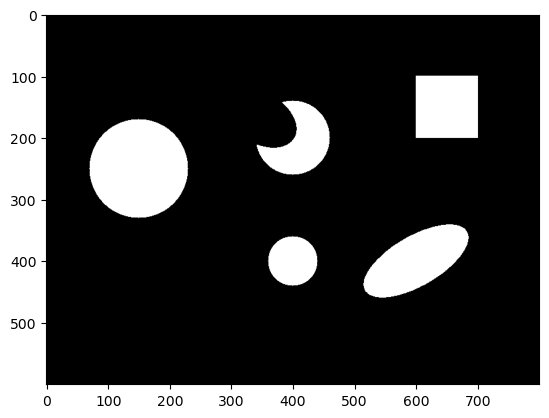

In [36]:
img = np.zeros((600, 800), dtype=np.uint8)
cv2.circle(img, center=(150, 250), radius=80, color=255, thickness=-1)
cv2.circle(img, center=(400, 400), radius=40, color=255, thickness=-1)
cv2.ellipse(img, center=(600, 400), axes=(40, 95), angle=60, startAngle=0, endAngle=360, color=255, thickness=-1)
cv2.rectangle(img, pt1=(600, 100), pt2=(700, 200), color=255, thickness=-1)
cv2.circle(img, center=(400, 200), radius=60, color=255, thickness=-1)
cv2.ellipse(img, center=(350, 170), axes=(40, 60), angle=120, startAngle=0, endAngle=360, color=0, thickness=-1)
plt.imshow(img, cmap='gray')

In [37]:
conts, _ = cv2.findContours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

In [38]:
moments = [cv2.moments(c) for c in conts]

In [39]:
m = moments[2]
m

{'m00': 19854.0,
 'm10': 2978100.0,
 'm01': 4963500.0,
 'm20': 478084146.3333333,
 'm11': 744525000.0,
 'm02': 1272244146.3333333,
 'm30': 81123365850.0,
 'm21': 119521036583.33333,
 'm12': 190836621950.0,
 'm03': 333745609750.0,
 'mu20': 31369146.333333313,
 'mu11': 0.0,
 'mu02': 31369146.333333254,
 'mu30': 0.0,
 'mu21': 0.0,
 'mu12': 1.1444091796875e-05,
 'mu03': 6.103515625e-05,
 'nu20': 0.07958050029274678,
 'nu11': 0.0,
 'nu02': 0.07958050029274663,
 'nu30': 0.0,
 'nu21': 0.0,
 'nu12': 2.0604462460123056e-16,
 'nu03': 1.0989046645398964e-15}

In [40]:
print(m['m10']/m['m00'], m['m01']/m['m00'])

150.0 250.0


In [41]:
for _ in moments:
  print(_['mu11'])


0.0
-9581421.005331516
0.0
-2041284.1810604334
0.0


Uzyskane w ten sposób wielkości mogą posłużyć jako cechy do dalszego przetwarzania, np. z użyciem technik uczenia maszynowego.

---

Inne przydatne operacje na konturach obejmują m.in. testowanie/naprawianie wypukłości czy znajdowanie minimalnego prostokąta opisującego:

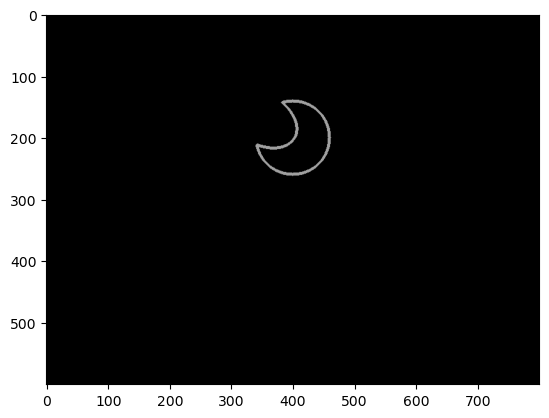

In [47]:
conts, _ = cv2.findContours(img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

display = np.zeros_like(img)
cv2.drawContours(display, conts, 3, color=160, thickness=3)
plt.imshow(display, cmap='gray', vmax=255)

In [43]:
cv2.isContourConvex(conts[3])

False

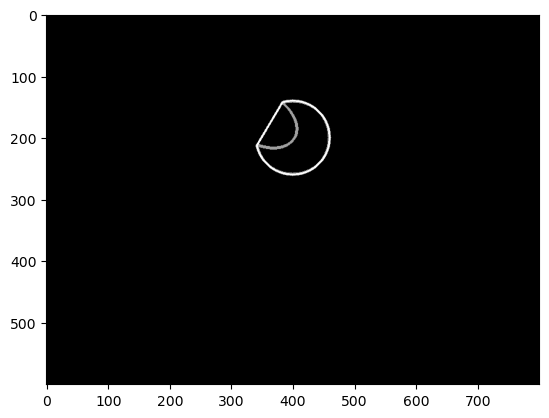

In [44]:
hull = cv2.convexHull(conts[3])
cv2.drawContours(display, [hull], 0, color=255, thickness=2)
plt.imshow(display, cmap='gray', vmax=255)

In [45]:
minRect = cv2.minAreaRect(conts[3])
minRect # zwróć uwagę na format wyniku: ((x, y), (w, h), kąt)

((406.935302734375, 204.12098693847656),
 (103.59812927246094, 119.73277282714844),
 30.718902587890625)

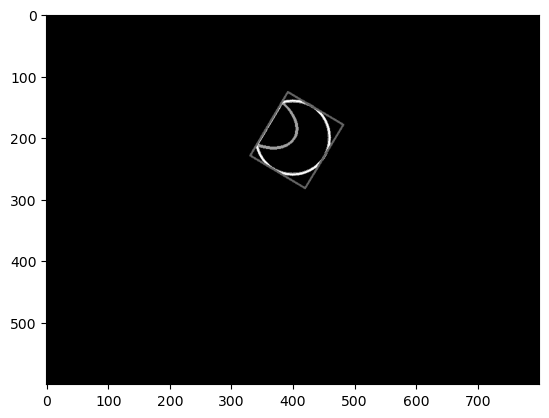

In [46]:
# do narysowania prostokąta potrzebne są jego punkty brzegowe (cv2.boxPoints)
# zwróć uwagę na rzutowanie do odpowiedniego typu - just OpenCV things
cv2.drawContours(display, [cv2.boxPoints(minRect).astype(np.int32)], 0, color=100, thickness=2)
plt.imshow(display, cmap='gray', vmax=255)